# Lab 14 Task 2 - YOLO

### SAHIL AMRITKAR
### 20BRS1180  


In [1]:
import cv2
import matplotlib.pyplot as plt

from utils import *
from darknet import Darknet

In [2]:
# Set the location and name of the cfg file
cfg_file = 'yolov3.cfg'

#DOWNLOAD WEIGHTS FILE FROM - https://pjreddie.com/media/files/yolov3.weights
# Set the location and name of the pre-trained weights file
weight_file = 'yolov3.weights'

# Set the location and name of the COCO object classes file
namesfile = 'classes.txt'

# Load the network architecture
m = Darknet(cfg_file)

# Load the pre-trained weights
m.load_weights(weight_file)

# Load the COCO object classes
class_names = load_class_names(namesfile)

In [3]:
# Print the neural network used in YOLOv3
m.print_network()

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32
    1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64
    2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32
    3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64
    4 shortcut 1
    5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128
    6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64
    7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
    8 shortcut 5
    9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64
   10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
   11 shortcut 8
   12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256
   13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128
   14 conv    256  3 x 3 / 1    52 x  52 x 128   ->    52 x  52 x 256
   15 shortcut 12
   16 conv    128  1 x 1

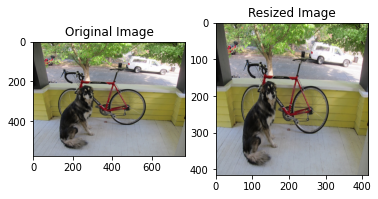

In [4]:
# Set the default figure size
plt.rcParams['figure.figsize'] = [24.0, 14.0]

# Load the image
img = cv2.imread('test_img.jpg')

# Convert the image to RGB
original_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# We resize the image to the input width and height of the first layer of the network.    
resized_image = cv2.resize(original_image, (m.width, m.height))

# Display the images
plt.subplot(121)
plt.title('Original Image')
plt.imshow(original_image)
plt.subplot(122)
plt.title('Resized Image')
plt.imshow(resized_image)
plt.show()

In [5]:
# Set the NMS threshold
nms_thresh = 0.6 

In [6]:
# Set the IOU threshold
iou_thresh = 0.4



It took 0.284 seconds to detect the objects in the image.

Number of Objects Detected: 3 

Objects Found and Confidence Level:

1. dog: 0.999997
2. truck: 0.991655
3. bicycle: 0.999998


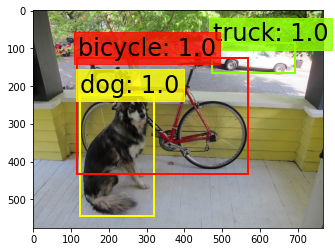

In [7]:
# Detect objects in the image
boxes = detect_objects(m, resized_image, iou_thresh, nms_thresh)

# Print the objects found and the confidence level
print_objects(boxes, class_names)

#Plot the image with bounding boxes and corresponding object class labels
plot_boxes(original_image, boxes, class_names, plot_labels = True)

## utils.py

In [ ]:
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches


def boxes_iou(box1, box2):
  
    # Get the Width and Height of each bounding box
    width_box1 = box1[2]
    height_box1 = box1[3]
    width_box2 = box2[2]
    height_box2 = box2[3]
    
    # Calculate the area of the each bounding box
    area_box1 = width_box1 * height_box1
    area_box2 = width_box2 * height_box2
    
    # Find the vertical edges of the union of the two bounding boxes
    mx = min(box1[0] - width_box1/2.0, box2[0] - width_box2/2.0)
    Mx = max(box1[0] + width_box1/2.0, box2[0] + width_box2/2.0)
    
    # Calculate the width of the union of the two bounding boxes
    union_width = Mx - mx
    
    # Find the horizontal edges of the union of the two bounding boxes
    my = min(box1[1] - height_box1/2.0, box2[1] - height_box2/2.0)
    My = max(box1[1] + height_box1/2.0, box2[1] + height_box2/2.0)    
    
    # Calculate the height of the union of the two bounding boxes
    union_height = My - my
    
    # Calculate the width and height of the area of intersection of the two bounding boxes
    intersection_width = width_box1 + width_box2 - union_width
    intersection_height = height_box1 + height_box2 - union_height
   
    # If the the boxes don't overlap then their IOU is zero
    if intersection_width <= 0 or intersection_height <= 0:
        return 0.0

    # Calculate the area of intersection of the two bounding boxes
    intersection_area = intersection_width * intersection_height
    
    # Calculate the area of the union of the two bounding boxes
    union_area = area_box1 + area_box2 - intersection_area
    
    # Calculate the IOU
    iou = intersection_area/union_area
    
    return iou


def nms(boxes, iou_thresh):
    
    # If there are no bounding boxes do nothing
    if len(boxes) == 0:
        return boxes
    
    # Create a PyTorch Tensor to keep track of the detection confidence
    # of each predicted bounding box
    det_confs = torch.zeros(len(boxes))
    
    # Get the detection confidence of each predicted bounding box
    for i in range(len(boxes)):
        det_confs[i] = boxes[i][4]

    # Sort the indices of the bounding boxes by detection confidence value in descending order.
    # We ignore the first returned element since we are only interested in the sorted indices
    _,sortIds = torch.sort(det_confs, descending = True)
    
    # Create an empty list to hold the best bounding boxes after
    # Non-Maximal Suppression (NMS) is performed
    best_boxes = []
    
    # Perform Non-Maximal Suppression 
    for i in range(len(boxes)):
        
        # Get the bounding box with the highest detection confidence first
        box_i = boxes[sortIds[i]]
        
        # Check that the detection confidence is not zero
        if box_i[4] > 0:
            
            # Save the bounding box 
            best_boxes.append(box_i)
            
            # Go through the rest of the bounding boxes in the list and calculate their IOU with
            # respect to the previous selected box_i. 
            for j in range(i + 1, len(boxes)):
                box_j = boxes[sortIds[j]]
                
                # If the IOU of box_i and box_j is higher than the given IOU threshold set
                # box_j's detection confidence to zero. 
                if boxes_iou(box_i, box_j) > iou_thresh:
                    box_j[4] = 0
                    
    return best_boxes


def detect_objects(model, img, iou_thresh, nms_thresh):
    
    # Start the time. This is done to calculate how long the detection takes.
    start = time.time()
    
    # Set the model to evaluation mode.
    model.eval()
    
    # Convert the image from a NumPy ndarray to a PyTorch Tensor of the correct shape.
    # The image is transposed, then converted to a FloatTensor of dtype float32, then
    # Normalized to values between 0 and 1, and finally unsqueezed to have the correct
    # shape of 1 x 3 x 416 x 416
    img = torch.from_numpy(img.transpose(2,0,1)).float().div(255.0).unsqueeze(0)
    
    # Feed the image to the neural network with the corresponding NMS threshold.
    # The first step in NMS is to remove all bounding boxes that have a very low
    # probability of detection. All predicted bounding boxes with a value less than
    # the given NMS threshold will be removed.
    list_boxes = model(img, nms_thresh)
    
    # Make a new list with all the bounding boxes returned by the neural network
    boxes = list_boxes[0][0] + list_boxes[1][0] + list_boxes[2][0]
    
    # Perform the second step of NMS on the bounding boxes returned by the neural network.
    # In this step, we only keep the best bounding boxes by eliminating all the bounding boxes
    # whose IOU value is higher than the given IOU threshold
    boxes = nms(boxes, iou_thresh)
    
    # Stop the time. 
    finish = time.time()
    
    # Print the time it took to detect objects
    print('\n\nIt took {:.3f}'.format(finish - start), 'seconds to detect the objects in the image.\n')
    
    # Print the number of objects detected
    print('Number of Objects Detected:', len(boxes), '\n')
    
    return boxes


def load_class_names(namesfile):
    
    # Create an empty list to hold the object classes
    class_names = []
    
    # Open the file containing the COCO object classes in read-only mode
    with open(namesfile, 'r') as fp:
        
        # The coco.names file contains only one object class per line.
        # Read the file line by line and save all the lines in a list.
        lines = fp.readlines()
    
    # Get the object class names
    for line in lines:
        
        # Make a copy of each line with any trailing whitespace removed
        line = line.rstrip()
        
        # Save the object class name into class_names
        class_names.append(line)
        
    return class_names


def print_objects(boxes, class_names):    
    print('Objects Found and Confidence Level:\n')
    for i in range(len(boxes)):
        box = boxes[i]
        if len(box) >= 7 and class_names:
            cls_conf = box[5]
            cls_id = box[6]
            print('%i. %s: %f' % (i + 1, class_names[cls_id], cls_conf))

            
def plot_boxes(img, boxes, class_names, plot_labels, color = None):
    
    # Define a tensor used to set the colors of the bounding boxes
    colors = torch.FloatTensor([[1,0,1],[0,0,1],[0,1,1],[0,1,0],[1,1,0],[1,0,0]])
    
    # Define a function to set the colors of the bounding boxes
    def get_color(c, x, max_val):
        ratio = float(x) / max_val * 5
        i = int(np.floor(ratio))
        j = int(np.ceil(ratio))
        
        ratio = ratio - i
        r = (1 - ratio) * colors[i][c] + ratio * colors[j][c]
        
        return int(r * 255)
    
    # Get the width and height of the image
    width = img.shape[1]
    height = img.shape[0]
    
    # Create a figure and plot the image
    fig, a = plt.subplots(1,1)
    a.imshow(img)
    
    # Plot the bounding boxes and corresponding labels on top of the image
    for i in range(len(boxes)):
        
        # Get the ith bounding box
        box = boxes[i]
        
        # Get the (x,y) pixel coordinates of the lower-left and lower-right corners
        # of the bounding box relative to the size of the image. 
        x1 = int(np.around((box[0] - box[2]/2.0) * width))
        y1 = int(np.around((box[1] - box[3]/2.0) * height))
        x2 = int(np.around((box[0] + box[2]/2.0) * width))
        y2 = int(np.around((box[1] + box[3]/2.0) * height))
        
        # Set the default rgb value to red
        rgb = (1, 0, 0)
            
        # Use the same color to plot the bounding boxes of the same object class
        if len(box) >= 7 and class_names:
            cls_conf = box[5]
            cls_id = box[6]
            classes = len(class_names)
            offset = cls_id * 123457 % classes
            red   = get_color(2, offset, classes) / 255
            green = get_color(1, offset, classes) / 255
            blue  = get_color(0, offset, classes) / 255
            
            # If a color is given then set rgb to the given color instead
            if color is None:
                rgb = (red, green, blue)
            else:
                rgb = color
        
        # Calculate the width and height of the bounding box relative to the size of the image.
        width_x = x2 - x1
        width_y = y1 - y2
        
        # Set the postion and size of the bounding box. (x1, y2) is the pixel coordinate of the
        # lower-left corner of the bounding box relative to the size of the image.
        rect = patches.Rectangle((x1, y2),
                                 width_x, width_y,
                                 linewidth = 2,
                                 edgecolor = rgb,
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
        
        # If plot_labels = True then plot the corresponding label
        if plot_labels:
            
            # Create a string with the object class name and the corresponding object class probability
            conf_tx = class_names[cls_id] + ': {:.1f}'.format(cls_conf)
            
            # Define x and y offsets for the labels
            lxc = (img.shape[1] * 0.266) / 100
            lyc = (img.shape[0] * 1.180) / 100
            
            # Draw the labels on top of the image
            a.text(x1 + lxc, y1 - lyc, conf_tx, fontsize = 24, color = 'k',
                   bbox = dict(facecolor = rgb, edgecolor = rgb, alpha = 0.8))        
        
    plt.show()

## darknet.py

In [ ]:
import torch
import torch.nn as nn
import numpy as np


class YoloLayer(nn.Module):
    def __init__(self, anchor_mask=[], num_classes=0, anchors=[], num_anchors=1):
        super(YoloLayer, self).__init__()
        self.anchor_mask = anchor_mask
        self.num_classes = num_classes
        self.anchors = anchors
        self.num_anchors = num_anchors
        self.anchor_step = len(anchors)/num_anchors
        self.coord_scale = 1
        self.noobject_scale = 1
        self.object_scale = 5
        self.class_scale = 1
        self.thresh = 0.6
        self.stride = 32
        self.seen = 0

    def forward(self, output, nms_thresh):
        self.thresh = nms_thresh
        masked_anchors = []
            
        for m in self.anchor_mask:
            masked_anchors += self.anchors[m*self.anchor_step:(m+1)*self.anchor_step]
                
        masked_anchors = [anchor/self.stride for anchor in masked_anchors]
        boxes = get_region_boxes(output.data, self.thresh, self.num_classes, masked_anchors, len(self.anchor_mask))
            
        return boxes

    
class Upsample(nn.Module):
    def __init__(self, stride=2):
        super(Upsample, self).__init__()
        self.stride = stride
    def forward(self, x):
        stride = self.stride
        assert(x.data.dim() == 4)
        B = x.data.size(0)
        C = x.data.size(1)
        H = x.data.size(2)
        W = x.data.size(3)
        ws = stride
        hs = stride
        x = x.view(B, C, H, 1, W, 1).expand(B, C, H, stride, W, stride).contiguous().view(B, C, H*stride, W*stride)
        return x


#for route and shortcut
class EmptyModule(nn.Module):
    def __init__(self):
        super(EmptyModule, self).__init__()

    def forward(self, x):
        return x

# support route shortcut
class Darknet(nn.Module):
    def __init__(self, cfgfile):
        super(Darknet, self).__init__()
        self.blocks = parse_cfg(cfgfile)
        self.models = self.create_network(self.blocks) # merge conv, bn,leaky
        self.loss = self.models[len(self.models)-1]

        self.width = int(self.blocks[0]['width'])
        self.height = int(self.blocks[0]['height'])

        self.header = torch.IntTensor([0,0,0,0])
        self.seen = 0

    def forward(self, x, nms_thresh):            
        ind = -2
        self.loss = None
        outputs = dict()
        out_boxes = []
        
        for block in self.blocks:
            ind = ind + 1
            if block['type'] == 'net':
                continue
            elif block['type'] in ['convolutional', 'upsample']: 
                x = self.models[ind](x)
                outputs[ind] = x
            elif block['type'] == 'route':
                layers = block['layers'].split(',')
                layers = [int(i) if int(i) > 0 else int(i)+ind for i in layers]
                if len(layers) == 1:
                    x = outputs[layers[0]]
                    outputs[ind] = x
                elif len(layers) == 2:
                    x1 = outputs[layers[0]]
                    x2 = outputs[layers[1]]
                    x = torch.cat((x1,x2),1)
                    outputs[ind] = x
            elif block['type'] == 'shortcut':
                from_layer = int(block['from'])
                activation = block['activation']
                from_layer = from_layer if from_layer > 0 else from_layer + ind
                x1 = outputs[from_layer]
                x2 = outputs[ind-1]
                x  = x1 + x2
                outputs[ind] = x
            elif block['type'] == 'yolo':
                boxes = self.models[ind](x, nms_thresh)
                out_boxes.append(boxes)
            else:
                print('unknown type %s' % (block['type']))
            
        return out_boxes
    

    def print_network(self):
        print_cfg(self.blocks)

    def create_network(self, blocks):
        models = nn.ModuleList()
    
        prev_filters = 3
        out_filters =[]
        prev_stride = 1
        out_strides = []
        conv_id = 0
        for block in blocks:
            if block['type'] == 'net':
                prev_filters = int(block['channels'])
                continue
            elif block['type'] == 'convolutional':
                conv_id = conv_id + 1
                batch_normalize = int(block['batch_normalize'])
                filters = int(block['filters'])
                kernel_size = int(block['size'])
                stride = int(block['stride'])
                is_pad = int(block['pad'])
                pad = (kernel_size-1)//2 if is_pad else 0
                activation = block['activation']
                model = nn.Sequential()
                if batch_normalize:
                    model.add_module('conv{0}'.format(conv_id), nn.Conv2d(prev_filters, filters, kernel_size, stride, pad, bias=False))
                    model.add_module('bn{0}'.format(conv_id), nn.BatchNorm2d(filters))
                else:
                    model.add_module('conv{0}'.format(conv_id), nn.Conv2d(prev_filters, filters, kernel_size, stride, pad))
                if activation == 'leaky':
                    model.add_module('leaky{0}'.format(conv_id), nn.LeakyReLU(0.1, inplace=True))
                prev_filters = filters
                out_filters.append(prev_filters)
                prev_stride = stride * prev_stride
                out_strides.append(prev_stride)
                models.append(model)
            elif block['type'] == 'upsample':
                stride = int(block['stride'])
                out_filters.append(prev_filters)
                prev_stride = prev_stride // stride
                out_strides.append(prev_stride)
                models.append(Upsample(stride))
            elif block['type'] == 'route':
                layers = block['layers'].split(',')
                ind = len(models)
                layers = [int(i) if int(i) > 0 else int(i)+ind for i in layers]
                if len(layers) == 1:
                    prev_filters = out_filters[layers[0]]
                    prev_stride = out_strides[layers[0]]
                elif len(layers) == 2:
                    assert(layers[0] == ind - 1)
                    prev_filters = out_filters[layers[0]] + out_filters[layers[1]]
                    prev_stride = out_strides[layers[0]]
                out_filters.append(prev_filters)
                out_strides.append(prev_stride)
                models.append(EmptyModule())
            elif block['type'] == 'shortcut':
                ind = len(models)
                prev_filters = out_filters[ind-1]
                out_filters.append(prev_filters)
                prev_stride = out_strides[ind-1]
                out_strides.append(prev_stride)
                models.append(EmptyModule())
            elif block['type'] == 'yolo':
                yolo_layer = YoloLayer()
                anchors = block['anchors'].split(',')
                anchor_mask = block['mask'].split(',')
                yolo_layer.anchor_mask = [int(i) for i in anchor_mask]
                yolo_layer.anchors = [float(i) for i in anchors]
                yolo_layer.num_classes = int(block['classes'])
                yolo_layer.num_anchors = int(block['num'])
                yolo_layer.anchor_step = len(yolo_layer.anchors)//yolo_layer.num_anchors
                yolo_layer.stride = prev_stride
                out_filters.append(prev_filters)
                out_strides.append(prev_stride)
                models.append(yolo_layer)
            else:
                print('unknown type %s' % (block['type']))
    
        return models

    def load_weights(self, weightfile):
        print()
        fp = open(weightfile, 'rb')
        header = np.fromfile(fp, count=5, dtype=np.int32)
        self.header = torch.from_numpy(header)
        self.seen = self.header[3]
        buf = np.fromfile(fp, dtype = np.float32)
        fp.close()

        start = 0
        ind = -2
        counter = 3
        for block in self.blocks:
            if start >= buf.size:
                break
            ind = ind + 1
            if block['type'] == 'net':
                continue
            elif block['type'] == 'convolutional':
                model = self.models[ind]
                batch_normalize = int(block['batch_normalize'])
                if batch_normalize:
                    start = load_conv_bn(buf, start, model[0], model[1])
                else:
                    start = load_conv(buf, start, model[0])
            elif block['type'] == 'upsample':
                pass
            elif block['type'] == 'route':
                pass
            elif block['type'] == 'shortcut':
                pass
            elif block['type'] == 'yolo':
                pass
            else:
                print('unknown type %s' % (block['type']))
            
            percent_comp = (counter / len(self.blocks)) * 100

            print('Loading weights. Please Wait...{:.2f}% Complete'.format(percent_comp), end = '\r', flush = True)

            counter += 1

            
            
def convert2cpu(gpu_matrix):
    return torch.FloatTensor(gpu_matrix.size()).copy_(gpu_matrix)


def convert2cpu_long(gpu_matrix):
    return torch.LongTensor(gpu_matrix.size()).copy_(gpu_matrix)


def get_region_boxes(output, conf_thresh, num_classes, anchors, num_anchors, only_objectness = 1, validation = False):
    anchor_step = len(anchors)//num_anchors
    if output.dim() == 3:
        output = output.unsqueeze(0)
    batch = output.size(0)
    assert(output.size(1) == (5+num_classes)*num_anchors)
    h = output.size(2)
    w = output.size(3)

    all_boxes = []
    output = output.view(batch*num_anchors, 5+num_classes, h*w).transpose(0,1).contiguous().view(5+num_classes, batch*num_anchors*h*w)

    grid_x = torch.linspace(0, w-1, w).repeat(h,1).repeat(batch*num_anchors, 1, 1).view(batch*num_anchors*h*w).type_as(output) #cuda()
    grid_y = torch.linspace(0, h-1, h).repeat(w,1).t().repeat(batch*num_anchors, 1, 1).view(batch*num_anchors*h*w).type_as(output) #cuda()
    xs = torch.sigmoid(output[0]) + grid_x
    ys = torch.sigmoid(output[1]) + grid_y

    anchor_w = torch.Tensor(anchors).view(num_anchors, anchor_step).index_select(1, torch.LongTensor([0]))
    anchor_h = torch.Tensor(anchors).view(num_anchors, anchor_step).index_select(1, torch.LongTensor([1]))
    anchor_w = anchor_w.repeat(batch, 1).repeat(1, 1, h*w).view(batch*num_anchors*h*w).type_as(output) #cuda()
    anchor_h = anchor_h.repeat(batch, 1).repeat(1, 1, h*w).view(batch*num_anchors*h*w).type_as(output) #cuda()
    ws = torch.exp(output[2]) * anchor_w
    hs = torch.exp(output[3]) * anchor_h

    det_confs = torch.sigmoid(output[4])
    cls_confs = torch.nn.Softmax(dim=1)(output[5:5+num_classes].transpose(0,1)).detach()
    cls_max_confs, cls_max_ids = torch.max(cls_confs, 1)
    cls_max_confs = cls_max_confs.view(-1)
    cls_max_ids = cls_max_ids.view(-1)

    
    sz_hw = h*w
    sz_hwa = sz_hw*num_anchors
    det_confs = convert2cpu(det_confs)
    cls_max_confs = convert2cpu(cls_max_confs)
    cls_max_ids = convert2cpu_long(cls_max_ids)
    xs = convert2cpu(xs)
    ys = convert2cpu(ys)
    ws = convert2cpu(ws)
    hs = convert2cpu(hs)
    if validation:
        cls_confs = convert2cpu(cls_confs.view(-1, num_classes))

    for b in range(batch):
        boxes = []
        for cy in range(h):
            for cx in range(w):
                for i in range(num_anchors):
                    ind = b*sz_hwa + i*sz_hw + cy*w + cx
                    det_conf =  det_confs[ind]
                    if only_objectness:
                        conf =  det_confs[ind]
                    else:
                        conf = det_confs[ind] * cls_max_confs[ind]
    
                    if conf > conf_thresh:
                        bcx = xs[ind]
                        bcy = ys[ind]
                        bw = ws[ind]
                        bh = hs[ind]
                        cls_max_conf = cls_max_confs[ind]
                        cls_max_id = cls_max_ids[ind]
                        box = [bcx/w, bcy/h, bw/w, bh/h, det_conf, cls_max_conf, cls_max_id]
                        if (not only_objectness) and validation:
                            for c in range(num_classes):
                                tmp_conf = cls_confs[ind][c]
                                if c != cls_max_id and det_confs[ind]*tmp_conf > conf_thresh:
                                    box.append(tmp_conf)
                                    box.append(c)
                        boxes.append(box)
        all_boxes.append(boxes)

    return all_boxes


def parse_cfg(cfgfile):
    blocks = []
    fp = open(cfgfile, 'r')
    block =  None
    line = fp.readline()
    while line != '':
        line = line.rstrip()
        if line == '' or line[0] == '#':
            line = fp.readline()
            continue        
        elif line[0] == '[':
            if block:
                blocks.append(block)
            block = dict()
            block['type'] = line.lstrip('[').rstrip(']')
            # set default value
            if block['type'] == 'convolutional':
                block['batch_normalize'] = 0
        else:
            key,value = line.split('=')
            key = key.strip()
            if key == 'type':
                key = '_type'
            value = value.strip()
            block[key] = value
        line = fp.readline()

    if block:
        blocks.append(block)
    fp.close()
    return blocks


def print_cfg(blocks):
    print('layer     filters    size              input                output');
    prev_width = 416
    prev_height = 416
    prev_filters = 3
    out_filters =[]
    out_widths =[]
    out_heights =[]
    ind = -2
    for block in blocks:
        ind = ind + 1
        if block['type'] == 'net':
            prev_width = int(block['width'])
            prev_height = int(block['height'])
            continue
        elif block['type'] == 'convolutional':
            filters = int(block['filters'])
            kernel_size = int(block['size'])
            stride = int(block['stride'])
            is_pad = int(block['pad'])
            pad = (kernel_size-1)//2 if is_pad else 0
            width = (prev_width + 2*pad - kernel_size)//stride + 1
            height = (prev_height + 2*pad - kernel_size)//stride + 1
            print('%5d %-6s %4d  %d x %d / %d   %3d x %3d x%4d   ->   %3d x %3d x%4d' % (ind, 'conv', filters, kernel_size, kernel_size, stride, prev_width, prev_height, prev_filters, width, height, filters))
            prev_width = width
            prev_height = height
            prev_filters = filters
            out_widths.append(prev_width)
            out_heights.append(prev_height)
            out_filters.append(prev_filters)
        elif block['type'] == 'upsample':
            stride = int(block['stride'])
            filters = prev_filters
            width = prev_width*stride
            height = prev_height*stride
            print('%5d %-6s           * %d   %3d x %3d x%4d   ->   %3d x %3d x%4d' % (ind, 'upsample', stride, prev_width, prev_height, prev_filters, width, height, filters))
            prev_width = width
            prev_height = height
            prev_filters = filters
            out_widths.append(prev_width)
            out_heights.append(prev_height)
            out_filters.append(prev_filters)
        elif block['type'] == 'route':
            layers = block['layers'].split(',')
            layers = [int(i) if int(i) > 0 else int(i)+ind for i in layers]
            if len(layers) == 1:
                print('%5d %-6s %d' % (ind, 'route', layers[0]))
                prev_width = out_widths[layers[0]]
                prev_height = out_heights[layers[0]]
                prev_filters = out_filters[layers[0]]
            elif len(layers) == 2:
                print('%5d %-6s %d %d' % (ind, 'route', layers[0], layers[1]))
                prev_width = out_widths[layers[0]]
                prev_height = out_heights[layers[0]]
                assert(prev_width == out_widths[layers[1]])
                assert(prev_height == out_heights[layers[1]])
                prev_filters = out_filters[layers[0]] + out_filters[layers[1]]
            out_widths.append(prev_width)
            out_heights.append(prev_height)
            out_filters.append(prev_filters)
        elif block['type'] in ['region', 'yolo']:
            print('%5d %-6s' % (ind, 'detection'))
            out_widths.append(prev_width)
            out_heights.append(prev_height)
            out_filters.append(prev_filters)
        elif block['type'] == 'shortcut':
            from_id = int(block['from'])
            from_id = from_id if from_id > 0 else from_id+ind
            print('%5d %-6s %d' % (ind, 'shortcut', from_id))
            prev_width = out_widths[from_id]
            prev_height = out_heights[from_id]
            prev_filters = out_filters[from_id]
            out_widths.append(prev_width)
            out_heights.append(prev_height)
            out_filters.append(prev_filters)
        else:
            print('unknown type %s' % (block['type']))

            
def load_conv(buf, start, conv_model):
    num_w = conv_model.weight.numel()
    num_b = conv_model.bias.numel()
    conv_model.bias.data.copy_(torch.from_numpy(buf[start:start+num_b]));   start = start + num_b
    conv_model.weight.data.copy_(torch.from_numpy(buf[start:start+num_w]).view_as(conv_model.weight.data)); start = start + num_w
    return start


def load_conv_bn(buf, start, conv_model, bn_model):
    num_w = conv_model.weight.numel()
    num_b = bn_model.bias.numel()
    bn_model.bias.data.copy_(torch.from_numpy(buf[start:start+num_b]));     start = start + num_b
    bn_model.weight.data.copy_(torch.from_numpy(buf[start:start+num_b]));   start = start + num_b
    bn_model.running_mean.copy_(torch.from_numpy(buf[start:start+num_b]));  start = start + num_b
    bn_model.running_var.copy_(torch.from_numpy(buf[start:start+num_b]));   start = start + num_b
    conv_model.weight.data.copy_(torch.from_numpy(buf[start:start+num_w]).view_as(conv_model.weight.data)); start = start + num_w
    return start